In [1]:
import os
import sys
import time
import yaml
import pandas as pd
import numpy as np

with open('../../config.local.yaml', 'r') as f:
    local_config = yaml.safe_load(f)

LOCAL_PATH = local_config['LOCAL_PATH']

sys.path.append(os.path.join(LOCAL_PATH, "src/python"))

import data_tools as dt

from matplotlib import pyplot as plt
from xgboost import XGBClassifier
import shap
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB

rng = np.random.default_rng(12898)

MAX_DOC_FREQ = 0.95    # ignore tokens that appear in 95% of documents
MIN_DOC_FREQ = 5       # ignore tokens that appear in less than 5 documents
MIN_DATES = 3          # ignore terms that appear in less than 2 dates

SUPPORT_TAGS = ['DEFINITELY SUPPORT', 'SOMEWHAT SUPPORT']
OPPOSE_TAGS = ['DEFINITELY OPPOSE', 'SOMEWHAT OPPOSE']


In [2]:
df = dt.get_supplemental_docs()

No proper response found for 2018-06-14, doc_id 1, pages 2-2


In [3]:
idx = df['support_or_oppose'].isin(SUPPORT_TAGS + OPPOSE_TAGS)
idx_support = df['support_or_oppose'].isin(SUPPORT_TAGS)
idx_oppose = df['support_or_oppose'].isin(OPPOSE_TAGS)

print(f"Number of documents: {idx.sum():,g}")
print(f"Number of support documents: {idx_support.sum():,g}")
print(f"Number of oppose documents: {idx_oppose.sum():,g}")

Number of documents: 4,525
Number of support documents: 2,099
Number of oppose documents: 2,426


In [4]:
# Keep only documents that either support or oppose
df2 = df.loc[idx].reset_index(drop=True)

In [5]:
pd.crosstab(df2['author_type'].fillna('NA'), df2['support_or_oppose'])

support_or_oppose,DEFINITELY OPPOSE,DEFINITELY SUPPORT,SOMEWHAT OPPOSE,SOMEWHAT SUPPORT
author_type,,,,
ADVOCACY GROUP,296,329,74,91
CONSULTANT,35,112,16,15
DEVELOPER,2,56,4,9
INDIVIDUAL,1640,1050,166,156
JOURNALIST,1,0,0,0
LAWYER,146,124,23,18
OTHER,6,14,2,1
PUBLIC OFFICIAL,6,106,9,18


In [6]:
minutes_df = dt.get_minutes()

No data found for 2021-01-14
No data found for 2022-03-17
No data found for 2022-10-13


In [7]:
minutes_df['n_support'] = 0
minutes_df['n_oppose'] = 0
for idx, irow in minutes_df.iterrows():
    date = irow['date']
    item_no = irow['item_no']
    for jdx, jrow in df2.loc[df2['date']==date].iterrows():
        referenced_items = [s.strip() for s in jrow['referenced_items'].split(',')]
        support_or_oppose = jrow['support_or_oppose']
        if item_no in referenced_items:
            minutes_df.loc[idx, 'n_support'] += 1*(support_or_oppose in SUPPORT_TAGS)
            minutes_df.loc[idx, 'n_oppose'] += 1*(support_or_oppose in OPPOSE_TAGS)

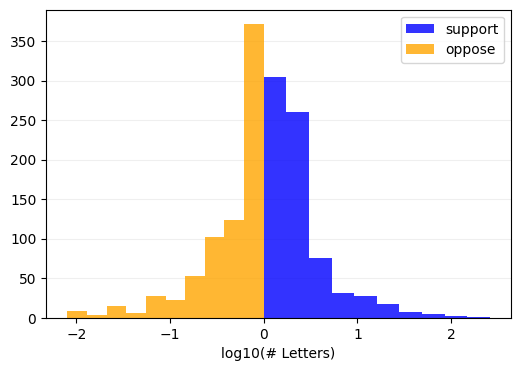

In [8]:
plt.figure(figsize=(6,4))
plt.hist(np.log10(minutes_df['n_support']+1), alpha=0.8, color='blue', label='support')
plt.hist(-np.log10(minutes_df['n_oppose']+1), alpha=0.8, color='orange', label='oppose')
plt.xlabel('log10(# Letters)')
plt.legend()
plt.grid(axis='y', alpha=0.2)
plt.gca().set_axisbelow(True)
plt.show()

In [9]:
# Build vocabulary. 

# Only include tokens that appear in the supplemental docs of at least 3 meetings
documents_by_date = []
for date in list(df2['date'].unique()):
    year = date[0:4]
    all_content = '\n\n'.join(list(df2.loc[df2['date']==date, 'content']))
    documents_by_date.append(all_content)

cv = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    min_df=MIN_DATES
)

X = cv.fit_transform(documents_by_date)
vocab = cv.get_feature_names_out()
vocab = [tok for tok in vocab if not tok.isdigit()]  # no pure numerical tokens

In [10]:
# Further refine the vocabulary
documents = list(df2['content'])
cv = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    max_df=MAX_DOC_FREQ,    # ignore tokens that appear in 95% of documents
    min_df=MIN_DOC_FREQ,    # include only tokens that appear at least twice
)
X = cv.fit_transform(documents)
vocab = cv.get_feature_names_out()

In [11]:
# Construct a token df
documents = list(df2['content'])
y = df2['support_or_oppose'].isin(SUPPORT_TAGS)
support_docs = list(df2.loc[y, 'content'])
oppose_docs = list(df2.loc[~y, 'content'])

count_vectorizer = CountVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab
)
tf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=False,
    norm=None
)
tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=True,
    norm=None
)

# On all documents
X = count_vectorizer.fit_transform(documents)
tokens = count_vectorizer.get_feature_names_out()
occurrences = X.sum(axis=0)
doc_freq = (X>0).sum(axis=0)
TF = tf_vectorizer.fit_transform(documents)
TFIDF = tfidf_vectorizer.fit_transform(documents)
IDF = tfidf_vectorizer.idf_

# On supports
X = count_vectorizer.fit_transform(support_docs)
occurrences_support = X.sum(axis=0)
doc_freq_support = (X>0).sum(axis=0)
TF_support = tf_vectorizer.fit_transform(support_docs)
TFIDF_support = tfidf_vectorizer.fit_transform(support_docs)
IDF_support = tfidf_vectorizer.idf_

# On opps
X = count_vectorizer.fit_transform(oppose_docs)
occurrences_oppose = X.sum(axis=0)
doc_freq_oppose = (X>0).sum(axis=0)
TF_oppose = tf_vectorizer.fit_transform(oppose_docs)
TFIDF_oppose = tfidf_vectorizer.fit_transform(oppose_docs)
IDF_oppose = tfidf_vectorizer.idf_


words_df = pd.DataFrame({
    'token': tokens, 'occurrences': occurrences.A1, 'doc_freq': doc_freq.A1,
    'tfidf': TFIDF.sum(axis=0).A1,
    'tfidf_support': (TF_support.multiply(IDF)).sum(axis=0).A1,
    'tfidf_oppose': (TF_oppose.multiply(IDF)).sum(axis=0).A1
})


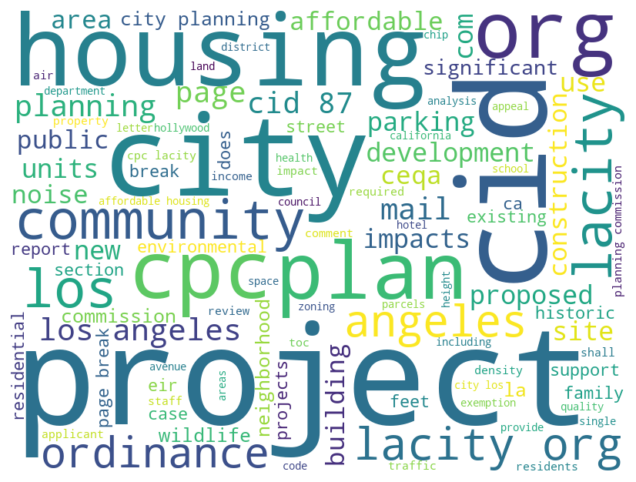

In [12]:
# Overall word cloud

wc_data = dict(zip(words_df['token'], words_df['tfidf']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [13]:
# xgboost binary classifier

tfidf_vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1,2),
    strip_accents='unicode',
    vocabulary=vocab,
    use_idf=True,
)

documents = list(df2['content'])
y = df2['support_or_oppose'].isin(SUPPORT_TAGS)

X = tfidf_vectorizer.fit_transform(documents)
feature_names = tfidf_vectorizer.get_feature_names_out()

model = XGBClassifier(eval_metric='logloss')
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [14]:
explainer = shap.Explainer(model)
shap_values = explainer(X)
importance_df = pd.DataFrame({
    'token': feature_names,
    'importance': shap_values.values.mean(axis=0)
})

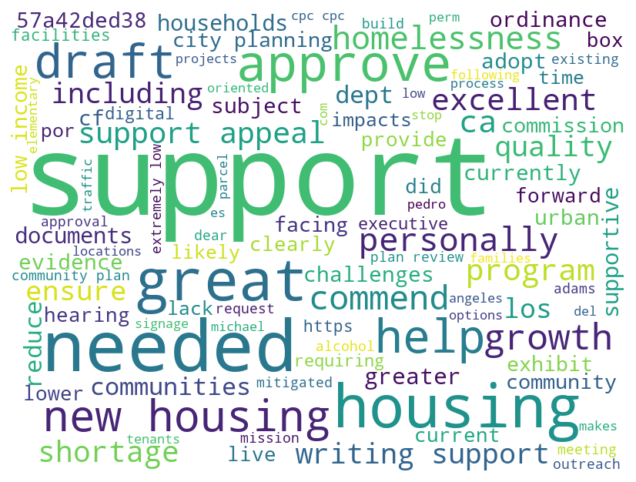

In [15]:
# Support Word Cloud

wc_data = dict(zip(importance_df['token'], importance_df['importance']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


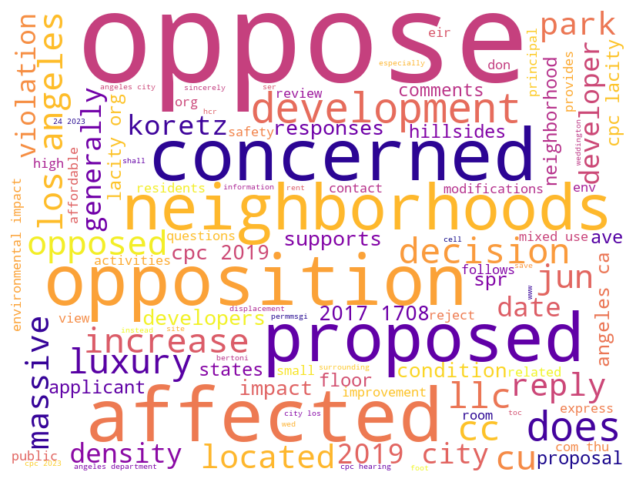

In [16]:
# Oppose Word Cloud

wc_data = dict(zip(importance_df['token'], -importance_df['importance']))

wordcloud = WordCloud(
    width=800,
    height=600,
    max_words=100,
    background_color='white',
    colormap='plasma'
).generate_from_frequencies(wc_data)

plt.figure(figsize=(8, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()
